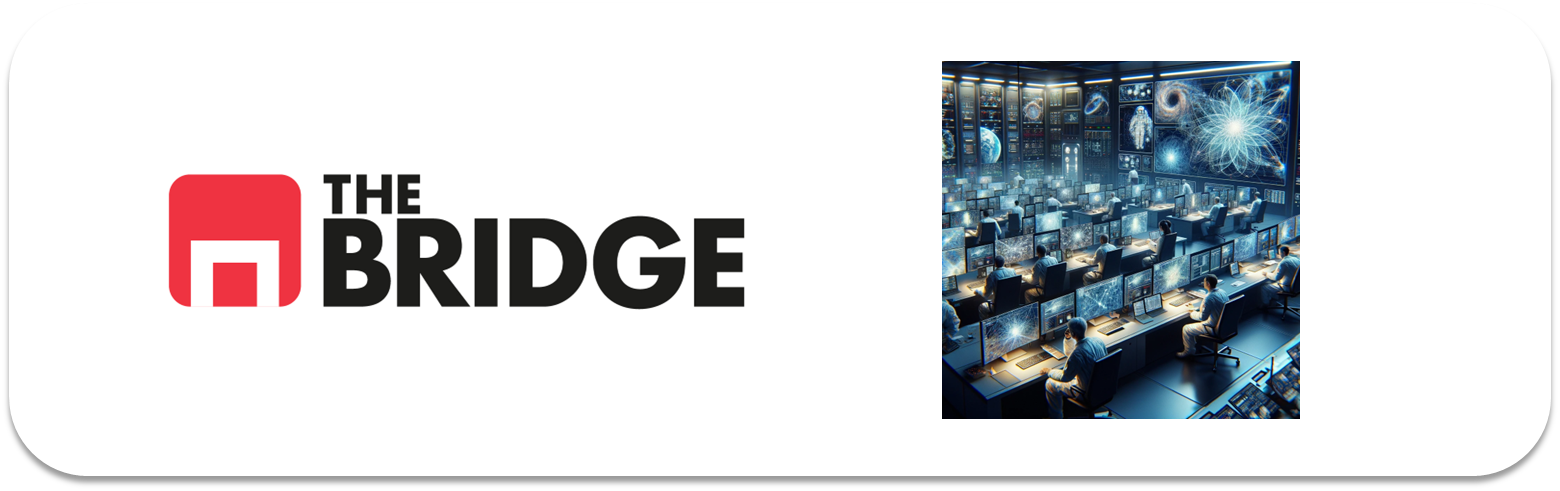

## PRACTICA OBLIGATORIA: **Transfer Learning y Fine Tuning**

* La práctica obligatoria de esta unidad consiste en un repetir el ejercicio de construcción de un modelo de clasificación de paisajes pero usando un modelo preentrenado. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

In [1]:
import cv2
import keras
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import seaborn as sns


from skimage.io import imread
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

### Objetivo del ejercicio

Comparar una red convolucional hecha ad-hoc frente a los modelos preentrenados y ajustados con fine tuning y transfer learning. Para ello emplea el dataset de paisajes del conjunto de ejercicios de la unidad anterior.


### Se pide

1. Preparar los datos del modelo y las funciones de visualización, copia para ello todo lo que necesites de las soluciones del ejercicio de clasificación de paisajes de la unidad anterior.

2. Escoger entre uno de los modelos VGG-19, InceptionV3 y MobileNetV2 (todos en https://keras.io/api/applications/) (Se aconseja este último si no tenemos un ordenador muy potente). Si no te haces con estos puedes recurrir a la ResNetV50.

4. Hacer un transfer-learning con una cabeza de como mucho 2 capas densas ocultas y una de salida. Mostrar la evaluación contra test, el report de clasificación y la matriz de confusión.

5. Hacer un fine-tuning con la misma cabeza diseñada en el punto anterior. Mostrar la evaluación contra test, el report de clasificación y la matriz de confusión.

6. Comparar los resultados con los obtenidos con la red convolucional del ejercicio mencionado.

EXTRA:
- Repetir el transfer learning empleando aumentado de imágenes.



In [2]:
ROOT_PATH = './data/'
TRAIN_PATH = ROOT_PATH + "seg_train/"
TEST_PATH = ROOT_PATH + "seg_test/"

In [3]:
def read_data(directorio, reshape_dim = (75,75)):
    X = [] 
    y = []
    for folder in os.listdir(directorio):
        print(folder)
        if os.path.isdir('/'.join([directorio, folder])):
            for file in os.listdir('/'.join([directorio, folder])):

                image = imread('/'.join([directorio, folder, file]))
                image = cv2.resize(image, reshape_dim) # Redimensionamos las imágenes a 32x32

                X.append(image)
                y.append(folder)

    return np.array(X),np.array(y)

def show_images_batch(paisajes, names = [], n_cols = 5, size_scale = 2):
    n_rows = ((len(paisajes) - 1) // n_cols + 1)
    plt.figure(figsize=(n_cols * size_scale, n_rows * 1.1*size_scale))
    for index, paisaje in enumerate(paisajes):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(paisaje, cmap = "Greys")
        plt.axis("off")
        if len(names):
            plt.title(names[index])

In [4]:
X_train,y_train = read_data('./data/seg_train/seg_train/')
X_test, y_test = read_data('./data/seg_test/seg_test/')

buildings
forest
glacier
mountain
sea
street
buildings
forest
glacier
mountain
sea
street


In [5]:
print('X train shape: ', X_train.shape)
print('Y train shape: ', y_train.shape)

X train shape:  (14034, 75, 75, 3)
Y train shape:  (14034,)


In [6]:
print('X test shape: ', X_test.shape)
print('Y test shape: ', y_test.shape)

X test shape:  (3000, 75, 75, 3)
Y test shape:  (3000,)


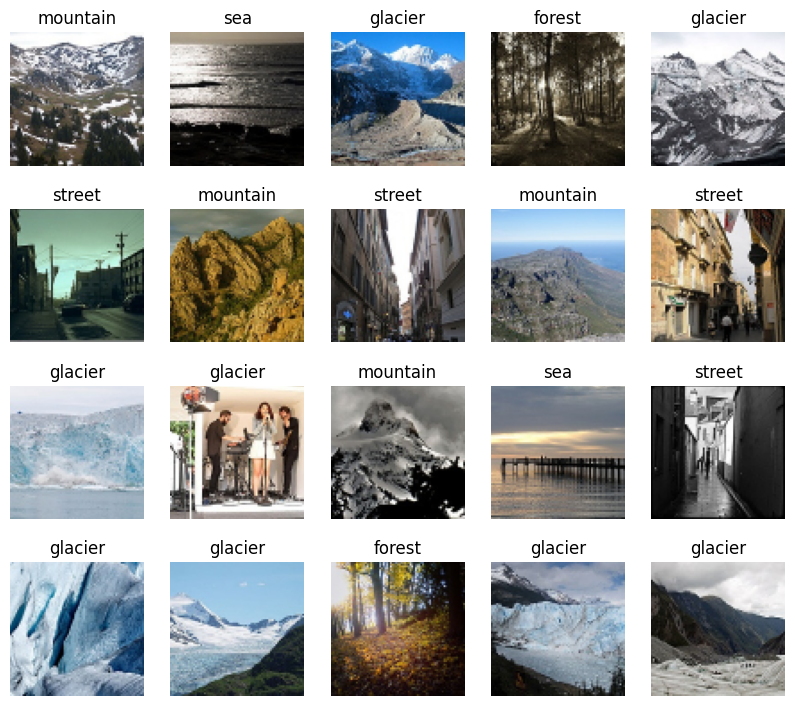

In [7]:
indices = np.random.randint(0,len(X_train),20)
show_images_batch(X_train[indices], names = y_train[indices], n_cols = 5)

In [8]:
targets = pd.Series(y_train)
targets.value_counts(True)

mountain     0.178994
glacier      0.171298
street       0.169731
sea          0.162035
forest       0.161821
buildings    0.156121
Name: proportion, dtype: float64

In [9]:
X_train = X_train/255
X_test = X_test/255

In [10]:
from keras.applications import InceptionV3

In [11]:
base_model = InceptionV3(include_top=False, weights='imagenet', input_shape=(75, 75, 3))

for layer in base_model.layers:
    layer.trainable = False

def prepare_model(base_model = base_model): 
    x = keras.layers.Flatten()(base_model.output)
    x = keras.layers.Dense(2048, activation='relu')(x)
    x = keras.layers.Dropout(rate = 0.25)(x)
    x = keras.layers.Dense(6, activation='softmax')(x)
    model = keras.Model(base_model.input, x)
    model.compile(optimizer = "adam", loss = 'sparse_categorical_crossentropy', metrics = ['acc']) # sparse -> y es un array de escalares pero hay varias categorias, y un array de vectores
    return model

In [12]:
model = prepare_model()


In [13]:
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 75, 75, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 37, 37,    │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 37, 37,    │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 37, 37,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 35, 35,    │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 35, 35,    │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 35, 35,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 35, 35,    │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 35, 35,    │        192 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 35, 35,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 17, 17,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 17, 17,    │      5,120 │ max_pooling2d[0]… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 17, 17,    │        240 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 17, 17,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 15, 15,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 15, 15,    │        576 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 15, 15,    │          0 │ batch_normalizat

 Total params: 26,011,430 (99.23 MB)

 Trainable params: 4,208,646 (16.05 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [14]:
targets = pd.Series(y_train)


In [15]:
mapa = {tipo:indice for indice,tipo in enumerate(targets.unique())} # Rehusando la serie que creamos para ver la distribución del target
mapa

{'buildings': 0,
 'forest': 1,
 'glacier': 2,
 'mountain': 3,
 'sea': 4,
 'street': 5}

In [16]:
y_train_num = np.array([mapa[y] for y in y_train])
y_test_num = np.array([mapa[y] for y in y_test])

In [17]:
X_train, y_train_num = shuffle(X_train, y_train_num)


In [18]:
history = model.fit(X_train,
                    y_train_num,
                    validation_split = 0.2,
                    epochs = 25,
                    batch_size = 128, callbacks= [keras.callbacks.EarlyStopping(patience = 10, restore_best_weights= True)]) 

Epoch 1/25
88/88 ━━━━━━━━━━━━━━━━━━━━ 36s 339ms/step - acc: 0.5817 - loss: 1.3033 - val_acc: 0.7638 - val_loss: 0.6657
Epoch 2/25
88/88 ━━━━━━━━━━━━━━━━━━━━ 26s 296ms/step - acc: 0.8254 - loss: 0.4822 - val_acc: 0.7667 - val_loss: 0.6553
Epoch 3/25
88/88 ━━━━━━━━━━━━━━━━━━━━ 27s 307ms/step - acc: 0.8695 - loss: 0.3577 - val_acc: 0.7684 - val_loss: 0.6611
Epoch 4/25
88/88 ━━━━━━━━━━━━━━━━━━━━ 30s 344ms/step - acc: 0.9128 - loss: 0.2637 - val_acc: 0.7570 - val_loss: 0.7227
Epoch 5/25
88/88 ━━━━━━━━━━━━━━━━━━━━ 29s 332ms/step - acc: 0.9515 - loss: 0.1681 - val_acc: 0.7563 - val_loss: 0.7898
Epoch 6/25
88/88 ━━━━━━━━━━━━━━━━━━━━ 29s 332ms/step - acc: 0.9765 - loss: 0.1039 - val_acc: 0.7581 - val_loss: 0.8364
Epoch 7/25
88/88 ━━━━━━━━━━━━━━━━━━━━ 29s 332ms/step - acc: 0.9889 - loss: 0.0682 - val_acc: 0.7634 - val_loss: 0.8981
Epoch 8/25
88/88 ━━━━━━━━━━━━━━━━━━━━ 30s 346ms/step - acc: 0.9923 - loss: 0.0527 - val_acc: 0.7627 - val_loss: 0.9195
Epoch 9/25
88/88 ━━━━━━━━━━━━━━━━━━━━ 31s 352ms/

In [19]:
history_df = pd.DataFrame(history.history)
history_df

,acc,loss,val_acc,val_loss
0,0.691280,0.881605,0.763805,0.665727
1,0.825777,0.481179,0.766655,0.655344
2,0.868620,0.361447,0.768436,0.661083
3,0.909949,0.264061,0.757036,0.722685
4,0.946736,0.173153,0.756323,0.789773
5,0.973457,0.106854,0.758105,0.836415
6,0.987085,0.068567,0.763449,0.898070
7,0.992696,0.048613,0.762736,0.919453
8,0.996170,0.031446,0.764161,0.968977
9,0.997684,0.024312,0.774492,0.981832


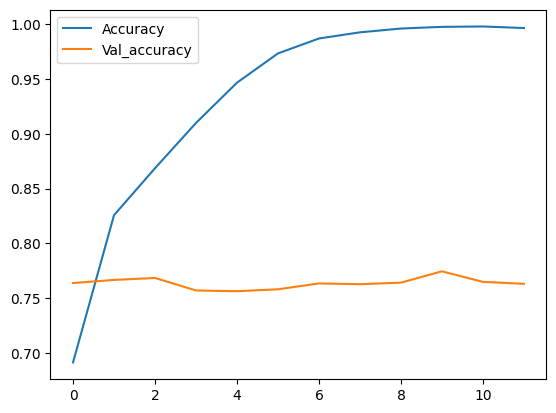

In [20]:
plt.plot(history_df['acc'], label = 'Accuracy')
plt.plot(history_df['val_acc'], label = 'Val_accuracy')

plt.legend()

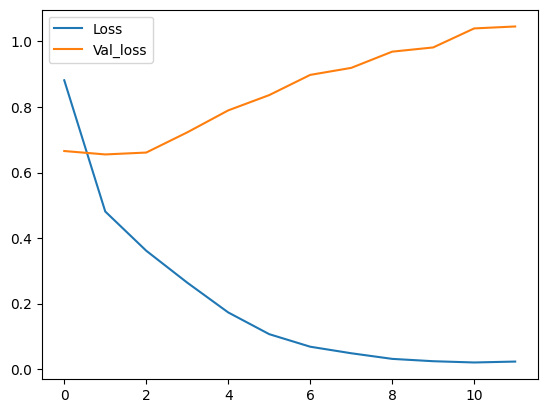

In [21]:
plt.plot(history_df['loss'], label = 'Loss')
plt.plot(history_df['val_loss'], label = 'Val_loss')

plt.legend()

In [22]:
model.evaluate(X_test,y_test_num)


94/94 ━━━━━━━━━━━━━━━━━━━━ 9s 100ms/step - acc: 0.7922 - loss: 0.5468


[0.6204091906547546, 0.7753333449363708]

In [23]:
y_pred = [np.argmax(prediction) for prediction in model.predict(X_test)]


94/94 ━━━━━━━━━━━━━━━━━━━━ 13s 116ms/step


In [24]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
inverse_map = {valor:clave for clave,valor in mapa.items()}
y_test_labels = [inverse_map[y] for y in y_test_num]
y_pred_labels = [inverse_map[y] for y in y_pred]
print(classification_report(y_test_labels, y_pred_labels))

              precision    recall  f1-score   support

   buildings       0.82      0.82      0.82       437
      forest       0.93      0.94      0.94       474
     glacier       0.76      0.59      0.67       553
    mountain       0.64      0.73      0.68       525
         sea       0.73      0.77      0.75       510
      street       0.81      0.83      0.82       501

    accuracy                           0.78      3000
   macro avg       0.78      0.78      0.78      3000
weighted avg       0.78      0.78      0.77      3000



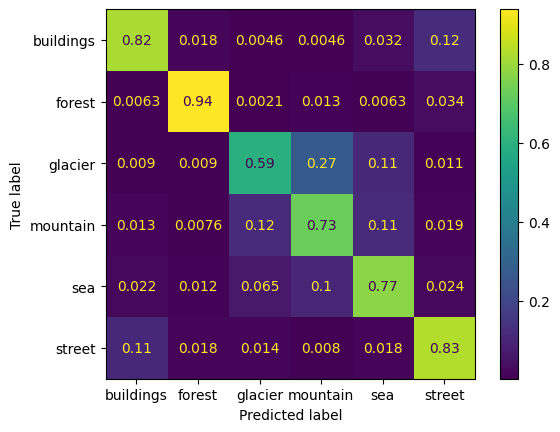

In [25]:
ConfusionMatrixDisplay.from_predictions(y_test_labels, y_pred_labels, normalize="true")


In [26]:
base_model = InceptionV3(include_top=False, weights=None, input_shape=(75, 75, 3))

def prepare_model(base_model = base_model):
    x = keras.layers.Flatten()(base_model.output)
    x = keras.layers.Dense(2048, activation='relu')(x)
    x = keras.layers.Dropout(rate = 0.25)(x)
    x = keras.layers.Dense(6, activation='softmax')(x)
    
    model_2 = keras.Model(base_model.input, x)
    model_2.compile(optimizer = "adam", loss = 'sparse_categorical_crossentropy', metrics = ['acc'])
    return model_2

In [27]:
model_2 = prepare_model()


In [28]:
history = model_2.fit(X_train,
                    y_train_num,
                    validation_split = 0.2,
                    epochs = 25,
                    batch_size = 128, callbacks= [keras.callbacks.EarlyStopping(patience = 10, restore_best_weights= True)]) 

Epoch 1/25
88/88 ━━━━━━━━━━━━━━━━━━━━ 172s 2s/step - acc: 0.4419 - loss: 1.7996 - val_acc: 0.1817 - val_loss: 1.7950
Epoch 2/25
88/88 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - acc: 0.6693 - loss: 0.9606 - val_acc: 0.1920 - val_loss: 2.4056
Epoch 3/25
88/88 ━━━━━━━━━━━━━━━━━━━━ 128s 1s/step - acc: 0.7621 - loss: 0.6987 - val_acc: 0.2487 - val_loss: 2.7530
Epoch 4/25
88/88 ━━━━━━━━━━━━━━━━━━━━ 137s 2s/step - acc: 0.7915 - loss: 0.5942 - val_acc: 0.3488 - val_loss: 2.0795
Epoch 5/25
88/88 ━━━━━━━━━━━━━━━━━━━━ 144s 2s/step - acc: 0.8262 - loss: 0.5030 - val_acc: 0.6448 - val_loss: 1.2375
Epoch 6/25
88/88 ━━━━━━━━━━━━━━━━━━━━ 157s 2s/step - acc: 0.8492 - loss: 0.4356 - val_acc: 0.7043 - val_loss: 0.9472
Epoch 7/25
88/88 ━━━━━━━━━━━━━━━━━━━━ 164s 2s/step - acc: 0.7747 - loss: 0.6798 - val_acc: 0.5558 - val_loss: 4.6088
Epoch 8/25
88/88 ━━━━━━━━━━━━━━━━━━━━ 164s 2s/step - acc: 0.8176 - loss: 0.5434 - val_acc: 0.7367 - val_loss: 0.9084
Epoch 9/25
88/88 ━━━━━━━━━━━━━━━━━━━━ 163s 2s/step - acc: 0.8584

In [29]:
history_df = pd.DataFrame(history.history)
history_df

,acc,loss,val_acc,val_loss
0,0.537009,1.413723,0.181689,1.794998
1,0.692883,0.875526,0.192020,2.405568
2,0.757192,0.700444,0.248664,2.753017
3,0.793088,0.592224,0.348771,2.079514
4,0.824619,0.508952,0.644817,1.237466
5,0.840296,0.458293,0.704311,0.947186
6,0.772067,0.678948,0.555753,4.608811
7,0.819453,0.525481,0.736730,0.908449
8,0.853924,0.414316,0.744211,0.835861
9,0.875657,0.358084,0.757748,0.931790


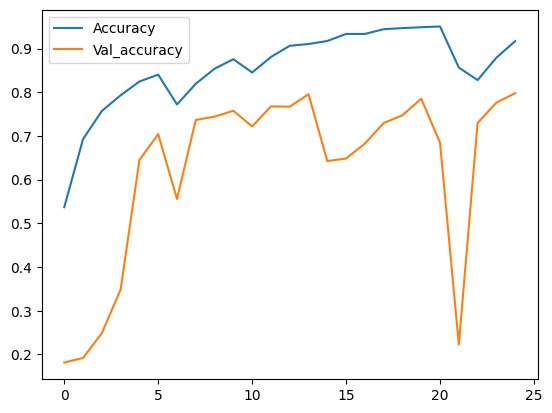

In [30]:
plt.plot(history_df['acc'], label = 'Accuracy')
plt.plot(history_df['val_acc'], label = 'Val_accuracy')

plt.legend()

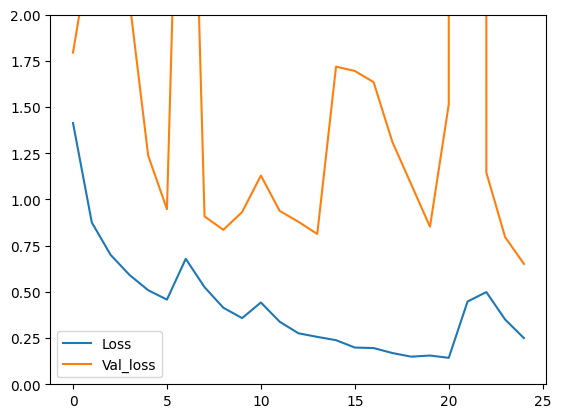

In [31]:
plt.plot(history_df['loss'], label = 'Loss')
plt.plot(history_df['val_loss'], label = 'Val_loss')
plt.ylim(0,2)
plt.legend()

In [32]:
model_2.evaluate(X_test,y_test_num)


94/94 ━━━━━━━━━━━━━━━━━━━━ 11s 113ms/step - acc: 0.8017 - loss: 0.6842


[0.634814441204071, 0.812333345413208]

In [33]:
y_pred = [np.argmax(prediction) for prediction in model_2.predict(X_test)]


94/94 ━━━━━━━━━━━━━━━━━━━━ 17s 150ms/step


In [34]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
inverse_map = {valor:clave for clave,valor in mapa.items()}
y_test_labels = [inverse_map[y] for y in y_test_num]
y_pred_labels = [inverse_map[y] for y in y_pred]
print(classification_report(y_test_labels, y_pred_labels))

              precision    recall  f1-score   support

   buildings       0.80      0.79      0.79       437
      forest       0.94      0.94      0.94       474
     glacier       0.89      0.60      0.72       553
    mountain       0.78      0.83      0.80       525
         sea       0.69      0.91      0.79       510
      street       0.85      0.83      0.84       501

    accuracy                           0.81      3000
   macro avg       0.82      0.82      0.81      3000
weighted avg       0.82      0.81      0.81      3000



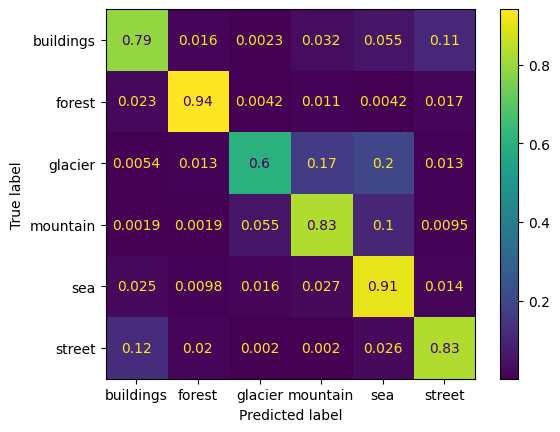

In [35]:
ConfusionMatrixDisplay.from_predictions(y_test_labels, y_pred_labels, normalize="true")
